<a href="https://colab.research.google.com/github/MingyuLyu/Railway-Optimal-Control-with-Reinforcement-Learning/blob/main/Stochastic_Environment_with_Friction_and_Traction_Power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install stable-baselines3[extra]
! pip install gymnasium[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 263.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 36.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-1

# Import Helpers


In [2]:
# Import Helpers
from typing import Any

import numpy as np
import random
import os

# Import Gymnasium stuff
import gymnasium as gym
from gymnasium import Env
from gymnasium.core import ObsType
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete

# Import Stable Baseline stuff
from stable_baselines3 import TD3, PPO, SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor

# Stocahtic Environment  (3 limits)

In [12]:
class TrainSpeedControl(Env):
    def __init__(self):
        self.dt = 0.1  # in s
        self.sensor_range = 300.0  # in m

        self.Mass = 300.0  # in Ton
        self.position = 0.0  # in m; track is 1-dim, only one coord is needed
        self.velocity = 0.0  # in m/s
        self.acceleration = 0.0  # in m/s**2
        self.Max_traction_F = 0.0  # in kN
        self.traction_power = 0.0  # in kW
        self.P_Max = 0.0  # in kW

        self.jerk = 0.0  # in m/s**3
        self.prev_action = 0.0  # [-1,1]
        self.time = 0.0  # in s
        self.total_energy_kWh = 0.0  # in Wh
        self.reward = 0.0

        self.reward_weights = [1.0, 0.0, 0.0, 1.0]
        self.energy_factor = 1.0
        self.friction_deceleration = 0.02

        self.track_length = 2500.0
        self.speed_limit_positions = [0.0, 1000.0, 2000.0]
        self.speed_limits = [15.0, 10.0, 0.0]


        self.terminated = False
        self.truncated = False
        self.done = False
        self.episode_count = 0
        self.reroll_frequency = 10

        (self.current_speed_limit, self.future_speed_limits,
         self.future_speed_limit_distances_speed_limit_distance) = self.sensor(self.position)

        self.specs = {
            'mass': 1000,
            'frontal_area': 2.38,
            'cW': 0.29,
            'acceleration_limits': [-1, 1],
            'velocity_limits': [-1, 100],
            'power_limits': [-50, 75],
            'track_length': [0, 2500]
        }

        """
        # Meaning of state features
        # 1. Train's current positon
        # 2. Train's current velocity
        # 3. Train's acceleration of last time step
        # 4. Current speed limit
        # 5. Next speed limit
        # 6. Distance to next speed limit
        """

        # self.state_max = np.hstack(
        #     (self.specs['velocity_limits'][1],
        #      self.specs['acceleration_limits'][1],
        #      self.specs['velocity_limits'][1],
        #      self.specs['velocity_limits'][1],
        #      self.specs['track_length'][1]))

        # self.state_min = np.hstack(
        #     (self.specs['velocity_limits'][0],
        #      self.specs['acceleration_limits'][0],
        #      self.specs['velocity_limits'][0],
        #      self.specs['velocity_limits'][0],
        #      self.specs['track_length'][0],))
        self.state_max = np.hstack(
              ( self.specs['track_length'][1],
                self.specs['velocity_limits'][1],
                self.specs['acceleration_limits'][1],
                self.specs['velocity_limits'][1],
                self.specs['velocity_limits'][1] * np.ones(2),
                self.sensor_range * np.ones(2)))

        self.state_min = np.hstack(
              ( self.specs['track_length'][0],
                self.specs['velocity_limits'][0],
                self.specs['acceleration_limits'][0],
                self.specs['velocity_limits'][0],
                self.specs['velocity_limits'][0] * np.ones(2),
                np.zeros(2)))

        self.action_space = Box(low=-1.0,
                                high=1.0,
                                shape=(1,),
                                dtype=np.float32)

        self.observation_space = Box(low=self.state_min,
                                     high=self.state_max,
                                     dtype=np.float64)

    def step(self, action):
        """
        Take one 10Hz step:
        Update time, position, velocity, jerk, limits.
        Check if episode is done.
        Get reward.
        :param action: float within (-1, 1)
        :return: state, reward, done, info
        """

        assert self.action_space.contains(action), \
            f'{action} ({type(action)}) invalid shape or bounds'

        action_clipped = np.clip(action, -1, 1)[0]
        # print("velocity:", self.velocity)
        # print("positon:", self.position)
        self.update_motion(action_clipped)


        # s = 0.5 * a * t² + v0 * t + s0
        # self.position += (0.5 * self.acceleration * self.dt ** 2 +
        #                   self.velocity * self.dt)
        # # v = a * t + v0
        # self.velocity += self.acceleration * self.dt

        # Update speed limit
        (self.current_speed_limit, self.future_speed_limits,
         self.future_speed_limit_distances) = self.sensor(self.position)

        # Update others
        self.time += self.dt
        self.jerk = abs(action_clipped - self.prev_action)
        self.prev_action = action_clipped

        # Judge terminated condition
        self.terminated = bool(self.position >= self.track_length or self.time > 210.0)
        if self.terminated:
          self.episode_count += 1

        self.truncated = False

        # Calculate reward
        reward_list = self.get_reward()
        # print("reward_list:", reward_list)
        self.reward = np.array(reward_list).dot(np.array(self.reward_weights))

        if self.position >= self.speed_limit_positions[2] and self.velocity < 0.1:
          self.reward += 1

        # Update info
        info = {
            'position': self.position,
            'velocity': self.velocity,
            'acceleration': self.acceleration,
            'jerk': self.jerk,
            'time': self.time,
            'energy': self.total_energy_kWh,
            'reward': self.reward,
            'action': action_clipped
        }

        # Update state
        # state = self.feature_scaling(self.get_state())
        state = np.hstack([self.position, self.velocity, self.prev_action, self.current_speed_limit,
                          self.future_speed_limits, self.future_speed_limit_distances])

        return state, self.reward, self.terminated, self.truncated, info

    def reset(
            self,
            *,
            seed: int | None = None,
            options: dict[str, Any] | None = None,
    ):
        self.position = 0.0  # in m; track is 1-dim, only one coord is needed
        self.velocity = 0.0  # in m/s
        self.acceleration = 0.0  # in m/s**2
        self.Max_traction_F = 0.0  # in kN
        self.P_max = 0.0  # in kW
        self.jerk = 0.0  # in m/s**3
        self.prev_action = 0.0  # in m/s**2
        self.time = 0.0  # in s
        self.total_energy_kWh = 0.0  # in Wh
        self.terminated = False
        self.truncated = False
        self.current_speed_limit = 0.0
        self.future_speed_limits = 0.0
        self.future_speed_limit_distances = 0.0


        # if self.episode_count % self.reroll_frequency == 0:
        #     second_limit_position = np.random.uniform(500, 1000)
        #     self.speed_limit_positions = [0.0, second_limit_position, 1800]
        #     self.speed_limits = np.append(np.random.randint(5, 21, size=2), 0.0)

        # Update to call sensor method to initialize speed limits correctly
        (self.current_speed_limit, self.future_speed_limits, self.future_speed_limit_distances) = self.sensor(self.position)
        # print("current_speed_limit:", self.current_speed_limit)
        info = {
            'position': self.position,
            'velocity': self.velocity,
            'acceleration': self.acceleration,
            'jerk': self.jerk,
            'time': self.time,
            'energy': self.total_energy_kWh,
            'reward': self.reward,
            'action': self.prev_action
        }


        # state = self.feature_scaling(self.get_state
        state = np.hstack([self.position, self.velocity, self.acceleration, self.current_speed_limit,
                           self.future_speed_limits, self.future_speed_limit_distances])
        return state, info


    def update_motion(self, action_clipped):
        resistance = self.Calc_Resistance()

        if self.velocity > 0:
            if action_clipped >= 0:
                force = action_clipped * self.Calc_Max_traction_F()
                # print("force1:", force)
                self.traction_power = force * self.velocity
            else:
                force = action_clipped * self.Calc_Max_braking_F()
                # print("force2:", force)
                self.traction_power = 0.0

            self.acceleration = (force - resistance) / self.Mass
            # Prevent reversing if velocity might turn negative
            if self.velocity + self.acceleration * self.dt < 0:
                self.acceleration = -self.velocity / self.dt

        elif self.velocity == 0:
            if action_clipped > 0:
                force = action_clipped * self.Calc_Max_traction_F()
                # print("force3:", force)

            else:
                force = 0
                # print("force4:", force)

            self.acceleration = max(0, (force - resistance) / self.Mass)
            self.traction_power = 0  # No power since velocity is 0 at this step

        # Update position and velocity using kinematic equations
        self.position += (0.5 * self.acceleration * self.dt ** 2 + self.velocity * self.dt)
        self.velocity += self.acceleration * self.dt



    def sensor(self, position):
    # Treat negative positions as 0
        if position < 0:
            position = 0

        current_speed_limit = 0.0
        current_speed_limit_i = 0
        next_speed_limit = 0.0
        next_speed_limit_distance = 0.0
          #next2_speed_limit = 0.0
          #next2_speed_limit_distance = 0.0

          # Determine the current speed limit
        for i, (pos, sl) in enumerate(
                zip(self.speed_limit_positions, self.speed_limits)):
          if pos <= position:
                current_speed_limit = sl
                current_speed_limit_i = i

        # Determine the current speed limit
        if current_speed_limit_i + 1 > len(self.speed_limits) - 1:
            next_speed_limit = current_speed_limit
            next_speed_limit_distance = self.sensor_range
        elif (self.speed_limit_positions[current_speed_limit_i + 1] - position
              > self.sensor_range):
            next_speed_limit = current_speed_limit
            next_speed_limit_distance = self.sensor_range
        else:
            next_speed_limit = self.speed_limits[current_speed_limit_i + 1]
            next_speed_limit_distance = self.speed_limit_positions[
                                          current_speed_limit_i + 1] - position

        if current_speed_limit_i + 2 > len(self.speed_limits) - 1:
            next2_speed_limit = next_speed_limit
            next2_speed_limit_distance = self.sensor_range
        elif (self.speed_limit_positions[current_speed_limit_i + 2] - position
              > self.sensor_range):
            next2_speed_limit = next_speed_limit
            next2_speed_limit_distance = self.sensor_range
        else:
            next2_speed_limit = self.speed_limits[current_speed_limit_i + 2]
            next2_speed_limit_distance = self.speed_limit_positions[
                                             current_speed_limit_i + 2] - position
        future_speed_limits = [next_speed_limit, next2_speed_limit]
        future_speed_limit_distances = [
            next_speed_limit_distance, next2_speed_limit_distance
        ]
        # future_speed_limits = next_speed_limit
        # future_speed_limit_distances = next_speed_limit_distance
        return (current_speed_limit, future_speed_limits,
                future_speed_limit_distances)

    def get_reward(self):
        """
        Calculate the reward for this time step.
        Requires current limits, velocity, acceleration, jerk, time.
        Get predicted energy rate (power) from car data.
        Use negative energy as reward.
        Use negative jerk as reward (scaled).
        Use velocity as reward (scaled).
        Use a shock penalty as reward.
        :return: reward
        """
        # calc forward or velocity reward
        reward_forward = abs(self.velocity - self.current_speed_limit) / (1 +
                                abs(self.velocity - self.current_speed_limit))

        # calc energy reward
        # if self.velocity >= 0:
        #   reward_energy = self.traction_power
        #   energy_max = self.Calc_Max_traction_F() * self.velocity
        #   reward_energy /= energy_max
        # else:
        reward_energy = 0

        # calc jerk reward
        reward_jerk = self.jerk/2

        # calc shock reward
        reward_shock = 1 if self.velocity > self.current_speed_limit else 0

        # print(f"reward_forward: {reward_forward}")
        # print(f"reward_energy: {reward_energy}")
        # print(f"reward_jerk: {reward_jerk}")
        # print(f"reward_shock: {reward_shock}")

        # print("reward_stop:", reward_stop

        reward_list = [
            -reward_forward, -reward_energy, -reward_jerk, -reward_shock]
        # print("reward_list:", reward_list)
        return reward_list

    def Calc_Max_traction_F(self):
        """
        Calculate the traction force based on the speed in m/s.

        Parameters:
        - speed (float): Speed in km/h

        Returns:
        - float: Traction force in kN
        """
        speed = self.velocity * 3.6  # Convert speed from m/s to km/h
        f_t = 263.9  # Initial traction force value in kN (acceleration phase)
        p_max = f_t * 43 / 3.6  # Maximum power during acceleration in kW

        # If power exceeds the maximum power limit, then limit the traction force
        if speed > 0:
          if (f_t * speed / 3.6) > p_max:
              f_t = p_max / (speed / 3.6)

          # Additional condition to limit the traction force
          if f_t > (263.9 * 43 * 50 / (speed ** 2)):
              f_t = 263.9 * 43 * 50 / (speed ** 2)
        if speed == 0:
            f_t = 263.9  # Set traction force to initial value if speed is 0

        return f_t

    def Calc_Max_braking_F(self):
        """
        Calculate the braking force based on the speed.

        Parameters:
        - speed (float): Speed in km/h

        Returns:
        - float: Braking force in kN
        """

        speed = self.velocity * 3.6  # Convert speed from m/s to km/h
        if speed <= 0:
            f_b = 200
        else:
            if speed > 0 and speed <= 5:
                f_b = 200
            elif speed > 5 and speed <= 48.5:
                f_b = 389
            elif speed > 48.5 and speed <= 80:
                f_b = 913962.5 / (speed ** 2)
            else:
                f_b = 200  # Assumes no braking force calculation outside specified range

        # Apply a final modification factor to the braking force
        # f_b = 0.8 * f_b

        return f_b

    def Calc_Resistance(self):
        """
        Calculate the basic resistance of a train running at a given speed.

        :param speed: Speed of the train in km/h
        :return: Basic resistance in kN
        """
        n = 24  # Number of axles
        N = 6  # Number of cars
        A = 10.64  # Cross-sectional area of the train in m^2
        speed = self.velocity * 3.6  # Convert speed from m/s to km/h

        f_r = (6.4 * self.Mass + 130 * n + 0.14 * self.Mass * abs(speed) +
              (0.046 + 0.0065 * (N - 1)) * A * speed**2) / 1000
        f_r = 0.1 * f_r
        return f_r


    def render(self):
        pass




In [ ]:
    def Max_traction_F(velocity):
        speed = velocity * 3.6  # Convert speed from m/s to km/h
        print("speed:", speed)
        f_t = 263.9  # Initial traction force value in kN (acceleration phase)
        p_max = f_t * 43 / 3.6  # Maximum power during acceleration in kW
        print("p_max:", p_max)
        # If power exceeds the maximum power limit, then limit the traction force
        if speed > 0:
          print(f_t * speed / 3.6)
          print(263.9 * 43 * 50 / (speed ** 2))
          if (f_t * speed / 3.6) > p_max:
              f_t = p_max / (speed / 3.6)

          # Additional condition to limit the traction force
          if f_t > (263.9 * 43 * 50 / (speed ** 2)):
              f_t = 263.9 * 43 * 50 / (speed ** 2)
        if speed == 0:
            f_t = 263.9  # Set traction force to initial value if speed is 0


        return f_t

    f = Max_traction_F(30)
    print(f)

    def Calc_Max_traction_F(speed):
        speed_km_h = speed * 3.6  # Convert speed from m/s to km/h
        f_t = 263.9  # Initial traction force value in kN (acceleration phase)
        p_max = f_t * 43 / 3.6  # Maximum power during acceleration in kW

        # If power exceeds the maximum power limit, then limit the traction force
        if (f_t * speed_km_h / 3.6) > p_max:
            f_t = p_max / (speed_km_h / 3.6)

        # Additional condition to limit the traction force
        if f_t > (263.9 * 43 * 50 / (speed_km_h ** 2)):
            f_t = 263.9 * 43 * 50 / (speed_km_h ** 2)

        return f_t

speed: 108.0
p_max: 3152.1388888888887
7916.999999999999
48.64411865569273
48.64411865569273


# Testing Environment

In [ ]:
class TrainSpeedControl(Env):
    def __init__(self):
        self.dt = 0.1  # in s
        self.sensor_range = 300.0  # in m

        self.Mass = 300.0  # in Ton
        self.position = 0.0  # in m; track is 1-dim, only one coord is needed
        self.velocity = 0.0  # in m/s
        self.acceleration = 0.0  # in m/s**2
        self.Max_traction_F = 0.0  # in kN
        self.traction_power = 0.0  # in kW
        self.P_Max = 0.0  # in kW
        self.prev_acceleration = 0.0

        self.jerk = 0.0  # in m/s**3
        self.prev_action = 0.0  # [-1,1]
        self.time = 0.0  # in s
        self.total_energy_kWh = 0.0  # in Wh
        self.reward = 0.0

        self.reward_weights = [1.0, 0.0, 0.0, 0.0]
        self.energy_factor = 1.0
        self.friction_deceleration = 0.02

        self.track_length = 2500.0
        self.speed_limit_positions = [0.0, 1000.0, 2000.0]
        self.speed_limits = [15.0, 10.0, 0.0]

        self.terminated = False
        self.truncated = False
        self.done = False
        self.episode_count = 0
        self.reroll_frequency = 10

        (self.current_speed_limit, self.future_speed_limits,
         self.future_speed_limit_distances_speed_limit_distance) = self.sensor(self.position)

        self.specs = {
            'mass': 1000,
            'frontal_area': 2.38,
            'cW': 0.29,
            'acceleration_limits': [-1, 1],
            'velocity_limits': [-1, 100],
            'power_limits': [-50, 75],
            'track_length': [0, 2500]
        }

        """
        # Meaning of state features
        # 1. Train's current positon
        # 2. Train's current velocity
        # 3. Train's acceleration of last time step
        # 4. Current speed limit
        # 5. Next speed limit
        # 6. Distance to next speed limit
        """

        # self.state_max = np.hstack(
        #     (self.specs['velocity_limits'][1],
        #      self.specs['acceleration_limits'][1],
        #      self.specs['velocity_limits'][1],
        #      self.specs['velocity_limits'][1],
        #      self.specs['track_length'][1]))

        # self.state_min = np.hstack(
        #     (self.specs['velocity_limits'][0],
        #      self.specs['acceleration_limits'][0],
        #      self.specs['velocity_limits'][0],
        #      self.specs['velocity_limits'][0],
        #      self.specs['track_length'][0],))
        self.state_max = np.hstack(
            (self.specs['track_length'][1],
             self.specs['velocity_limits'][1],
             self.specs['acceleration_limits'][1],
             self.specs['velocity_limits'][1],
             self.specs['velocity_limits'][1] * np.ones(2),
             self.sensor_range * np.ones(2)))

        self.state_min = np.hstack(
            (self.specs['track_length'][0],
             self.specs['velocity_limits'][0],
             self.specs['acceleration_limits'][0],
             self.specs['velocity_limits'][0],
             self.specs['velocity_limits'][0] * np.ones(2),
             np.zeros(2)))

        self.action_space = Box(low=-1.0,
                                high=1.0,
                                shape=(1,),
                                dtype=np.float32)

        self.observation_space = Box(low=self.state_min,
                                     high=self.state_max,
                                     dtype=np.float64)

    def step(self, action):
        """
        Take one 10Hz step:
        Update time, position, velocity, jerk, limits.
        Check if episode is done.
        Get reward.
        :param action: float within (-1, 1)
        :return: state, reward, done, info
        """

        assert self.action_space.contains(action), \
            f'{action} ({type(action)}) invalid shape or bounds'

        # action_clipped = np.clip(action, -1, 1)[0]

        # self.update_motion(action_clipped)
        self.acceleration = np.clip(action, -1, 1)[0]
        # s = 0.5 * a * t² + v0 * t + s0
        self.position += (0.5 * self.acceleration * self.dt ** 2 +
                          self.velocity * self.dt)
        # v = a * t + v0
        self.velocity += self.acceleration * self.dt

        # Update speed limit
        (self.current_speed_limit, self.future_speed_limits,
         self.future_speed_limit_distances) = self.sensor(self.position)

        # Update others
        self.time += self.dt
        # self.jerk = abs(action_clipped - self.prev_action)
        # self.prev_action = action_clipped

        self.jerk = abs((self.acceleration - self.prev_acceleration)) / self.dt
        self.prev_acceleration = self.acceleration

        # Judge terminated condition
        self.terminated = bool(self.position >= self.track_length or self.time > 210.0)
        if self.terminated:
            self.episode_count += 1

        self.truncated = False

        # Calculate reward
        reward_list = self.get_reward()
        # print("reward_list:", reward_list)
        self.reward = np.array(reward_list).dot(np.array(self.reward_weights))

        if self.position >= self.speed_limit_positions[2] and self.velocity < 0.1:
          self.reward += 1

        # Update info
        info = {
            'position': self.position,
            'velocity': self.velocity,
            'acceleration': self.acceleration,
            'jerk': self.jerk,
            'time': self.time,
            'energy': self.total_energy_kWh,
            'reward': self.reward,
            'action': action
        }

        # Update state
        # state = self.feature_scaling(self.get_state())
        state = np.hstack([self.position, self.velocity, self.prev_action, self.current_speed_limit,
                           self.future_speed_limits, self.future_speed_limit_distances])

        return state, self.reward, self.terminated, self.truncated, info

    def reset(
            self,
            *,
            seed: int | None = None,
            options: dict[str, Any] | None = None,
    ):
        self.position = 0.0  # in m; track is 1-dim, only one coord is needed
        self.velocity = 0.0  # in m/s
        self.acceleration = 0.0  # in m/s**2
        self.Max_traction_F = 0.0  # in kN
        self.P_max = 0.0  # in kW
        self.jerk = 0.0  # in m/s**3
        self.prev_action = 0.0  # in m/s**2
        self.time = 0.0  # in s
        self.total_energy_kWh = 0.0  # in Wh
        self.terminated = False
        self.truncated = False
        self.current_speed_limit = 0.0
        self.future_speed_limits = 0.0
        self.future_speed_limit_distances = 0.0

        # if self.episode_count % self.reroll_frequency == 0:
        #     second_limit_position = np.random.uniform(500, 1000)
        #     self.speed_limit_positions = [0.0, second_limit_position, 1800]
        #     self.speed_limits = np.append(np.random.randint(5, 21, size=2), 0.0)

        # Update to call sensor method to initialize speed limits correctly
        (self.current_speed_limit, self.future_speed_limits, self.future_speed_limit_distances) = self.sensor(
            self.position)
        # print("current_speed_limit:", self.current_speed_limit)
        info = {
            'position': self.position,
            'velocity': self.velocity,
            'acceleration': self.acceleration,
            'jerk': self.jerk,
            'time': self.time,
            'energy': self.total_energy_kWh,
            'reward': self.reward,
            'action': self.prev_action
        }

        # state = self.feature_scaling(self.get_state
        state = np.hstack([self.position, self.velocity, self.acceleration, self.current_speed_limit,
                           self.future_speed_limits, self.future_speed_limit_distances])
        return state, info

    def update_motion(self, action_clipped):
        resistance = self.Calc_Resistance()

        if self.velocity > 0:
            if action_clipped >= 0:
                force = action_clipped * self.Calc_Max_traction_F()
                # print("force1:", force)
                self.traction_power = force * self.velocity
            else:
                force = action_clipped * self.Calc_Max_braking_F()
                # print("force2:", force)
                self.traction_power = 0.0

            self.acceleration = (force - resistance) / self.Mass
            # Prevent reversing if velocity might turn negative
            if self.velocity + self.acceleration * self.dt < 0:
                self.acceleration = -self.velocity / self.dt

        elif self.velocity == 0:
            if action_clipped > 0:
                force = action_clipped * self.Calc_Max_traction_F()
                # print("force3:", force)

            else:
                force = 0
                # print("force4:", force)

            self.acceleration = max(0, (force - resistance) / self.Mass)
            self.traction_power = 0  # No power since velocity is 0 at this step

        # Update position and velocity using kinematic equations
        self.position += (0.5 * self.acceleration * self.dt ** 2 + self.velocity * self.dt)
        self.velocity += self.acceleration * self.dt

    def sensor(self, position):
        # Treat negative positions as 0
        if position < 0:
            position = 0

        current_speed_limit = 0.0
        current_speed_limit_i = 0
        next_speed_limit = 0.0
        next_speed_limit_distance = 0.0
        # next2_speed_limit = 0.0
        # next2_speed_limit_distance = 0.0

        # Determine the current speed limit
        for i, (pos, sl) in enumerate(
                zip(self.speed_limit_positions, self.speed_limits)):
            if pos <= position:
                current_speed_limit = sl
                current_speed_limit_i = i

        # Determine the current speed limit
        if current_speed_limit_i + 1 > len(self.speed_limits) - 1:
            next_speed_limit = current_speed_limit
            next_speed_limit_distance = self.sensor_range
        elif (self.speed_limit_positions[current_speed_limit_i + 1] - position
              > self.sensor_range):
            next_speed_limit = current_speed_limit
            next_speed_limit_distance = self.sensor_range
        else:
            next_speed_limit = self.speed_limits[current_speed_limit_i + 1]
            next_speed_limit_distance = self.speed_limit_positions[
                                            current_speed_limit_i + 1] - position

        if current_speed_limit_i + 2 > len(self.speed_limits) - 1:
            next2_speed_limit = next_speed_limit
            next2_speed_limit_distance = self.sensor_range
        elif (self.speed_limit_positions[current_speed_limit_i + 2] - position
              > self.sensor_range):
            next2_speed_limit = next_speed_limit
            next2_speed_limit_distance = self.sensor_range
        else:
            next2_speed_limit = self.speed_limits[current_speed_limit_i + 2]
            next2_speed_limit_distance = self.speed_limit_positions[
                                             current_speed_limit_i + 2] - position
        future_speed_limits = [next_speed_limit, next2_speed_limit]
        future_speed_limit_distances = [
            next_speed_limit_distance, next2_speed_limit_distance
        ]
        # future_speed_limits = next_speed_limit
        # future_speed_limit_distances = next_speed_limit_distance
        return (current_speed_limit, future_speed_limits,
                future_speed_limit_distances)

    def get_reward(self):
        """
        Calculate the reward for this time step.
        Requires current limits, velocity, acceleration, jerk, time.
        Get predicted energy rate (power) from car data.
        Use negative energy as reward.
        Use negative jerk as reward (scaled).
        Use velocity as reward (scaled).
        Use a shock penalty as reward.
        :return: reward
        """
        # calc forward or velocity reward
        reward_forward = abs(self.velocity - self.current_speed_limit) / (1 +
                                                                          abs(self.velocity - self.current_speed_limit))

        # calc energy reward
        # if self.velocity >= 0:
        #   reward_energy = self.traction_power
        #   energy_max = self.Calc_Max_traction_F() * self.velocity
        #   reward_energy /= energy_max
        # else:
        reward_energy = 0

        # calc jerk reward
        reward_jerk = self.jerk / 2

        # calc shock reward
        reward_shock = 1 if self.velocity > self.current_speed_limit else 0

        # print(f"reward_forward: {reward_forward}")
        # print(f"reward_energy: {reward_energy}")
        # print(f"reward_jerk: {reward_jerk}")
        # print(f"reward_shock: {reward_shock}")

        # print("reward_stop:", reward_stop

        reward_list = [
            -reward_forward, -reward_energy, -reward_jerk, -reward_shock]
        # print("reward_list:", reward_list)
        return reward_list

    def Calc_Max_traction_F(self):
        """
        Calculate the traction force based on the speed in m/s.

        Parameters:
        - speed (float): Speed in km/h

        Returns:
        - float: Traction force in kN
        """
        speed = self.velocity * 3.6  # Convert speed from m/s to km/h
        f_t = 263.9  # Initial traction force value in kN (acceleration phase)
        p_max = f_t * 43 / 3.6  # Maximum power during acceleration in kW

        # If power exceeds the maximum power limit, then limit the traction force
        if speed > 0:
            if (f_t * speed / 3.6) > p_max:
                f_t = p_max / (speed / 3.6)

            # Additional condition to limit the traction force
            if f_t > (263.9 * 43 * 50 / (speed ** 2)):
                f_t = 263.9 * 43 * 50 / (speed ** 2)
        if speed == 0:
            f_t = 263.9  # Set traction force to initial value if speed is 0

        return f_t

    def Calc_Max_braking_F(self):
        """
        Calculate the braking force based on the speed.

        Parameters:
        - speed (float): Speed in km/h

        Returns:
        - float: Braking force in kN
        """

        speed = self.velocity * 3.6  # Convert speed from m/s to km/h
        if speed <= 0:
            f_b = 200
        else:
            if speed > 0 and speed <= 5:
                f_b = 200
            elif speed > 5 and speed <= 48.5:
                f_b = 389
            elif speed > 48.5 and speed <= 80:
                f_b = 913962.5 / (speed ** 2)
            else:
                f_b = 200  # Assumes no braking force calculation outside specified range

        # Apply a final modification factor to the braking force
        # f_b = 0.8 * f_b

        return f_b

    def Calc_Resistance(self):
        """
        Calculate the basic resistance of a train running at a given speed.

        :param speed: Speed of the train in km/h
        :return: Basic resistance in kN
        """
        n = 24  # Number of axles
        N = 6  # Number of cars
        A = 10.64  # Cross-sectional area of the train in m^2
        speed = self.velocity * 3.6  # Convert speed from m/s to km/h

        f_r = (6.4 * self.Mass + 130 * n + 0.14 * self.Mass * abs(speed) +
               (0.046 + 0.0065 * (N - 1)) * A * speed ** 2) / 1000
        f_r = 0.1 * f_r
        return f_r

    def render(self):
        pass

# Training

In [ ]:
env = TrainSpeedControl()
# check_env(env, warn=True)
log_path = os.path.join('Training', 'Logs')
checkpoint_path = os.path.join('Training', 'Saved Models')

# Create checkpoint callback
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path=checkpoint_path,
                                         name_prefix='SAC_model')

model = SAC("MlpPolicy", env, verbose=1, tensorboard_log=log_path)
model.learn(total_timesteps=10, callback=checkpoint_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to Training/Logs/SAC_8


# Load Model

In [6]:
from google.colab import drive
env = TrainSpeedControl()
drive.mount('/content/drive')
SAC_Path = '/content/drive/MyDrive/Colab Notebooks/TrainSpeedProject/SAC_model_2300000_steps.zip'
env = TrainSpeedControl()
model = SAC.load(SAC_Path, env=env)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


# Evalutation

In [ ]:
model = SAC.load(SAC_Path, env=env)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


AttributeError: 'TrainSpeedControl' object has no attribute 'prev_acceleration'

# Testing

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume TrainSpeedControl and model are already defined and imported

env = TrainSpeedControl()
episodes = 1
for episode in range(1, episodes + 1):
    obs, info = env.reset()
    print("current_speed_limit:", env.current_speed_limit)
    terminated = False
    score = 0
    data = []
    time_data = []
    velocity_data = []
    position_data = []
    acceleration_data = []
    reward_data = []
    action_data = []

    while not terminated:
        env.render()
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        score += reward
        info['episode'] = episode
        data.append(info)
        time_data.append(info['time'])
        velocity_data.append(info['velocity'])
        position_data.append(info['position'])
        acceleration_data.append(info['acceleration'])
        reward_data.append(reward)
        action_data.append(info['action'])

    print('Episode:{} Score:{}'.format(episode, score))

    df = pd.DataFrame(data)
    df.to_csv('/content/drive/MyDrive/Colab Notebooks/TrainSpeedProject/info_data.csv', index=False)




current_speed_limit: 15.0
Episode:1 Score:-207.69535357857563


## Figure plot

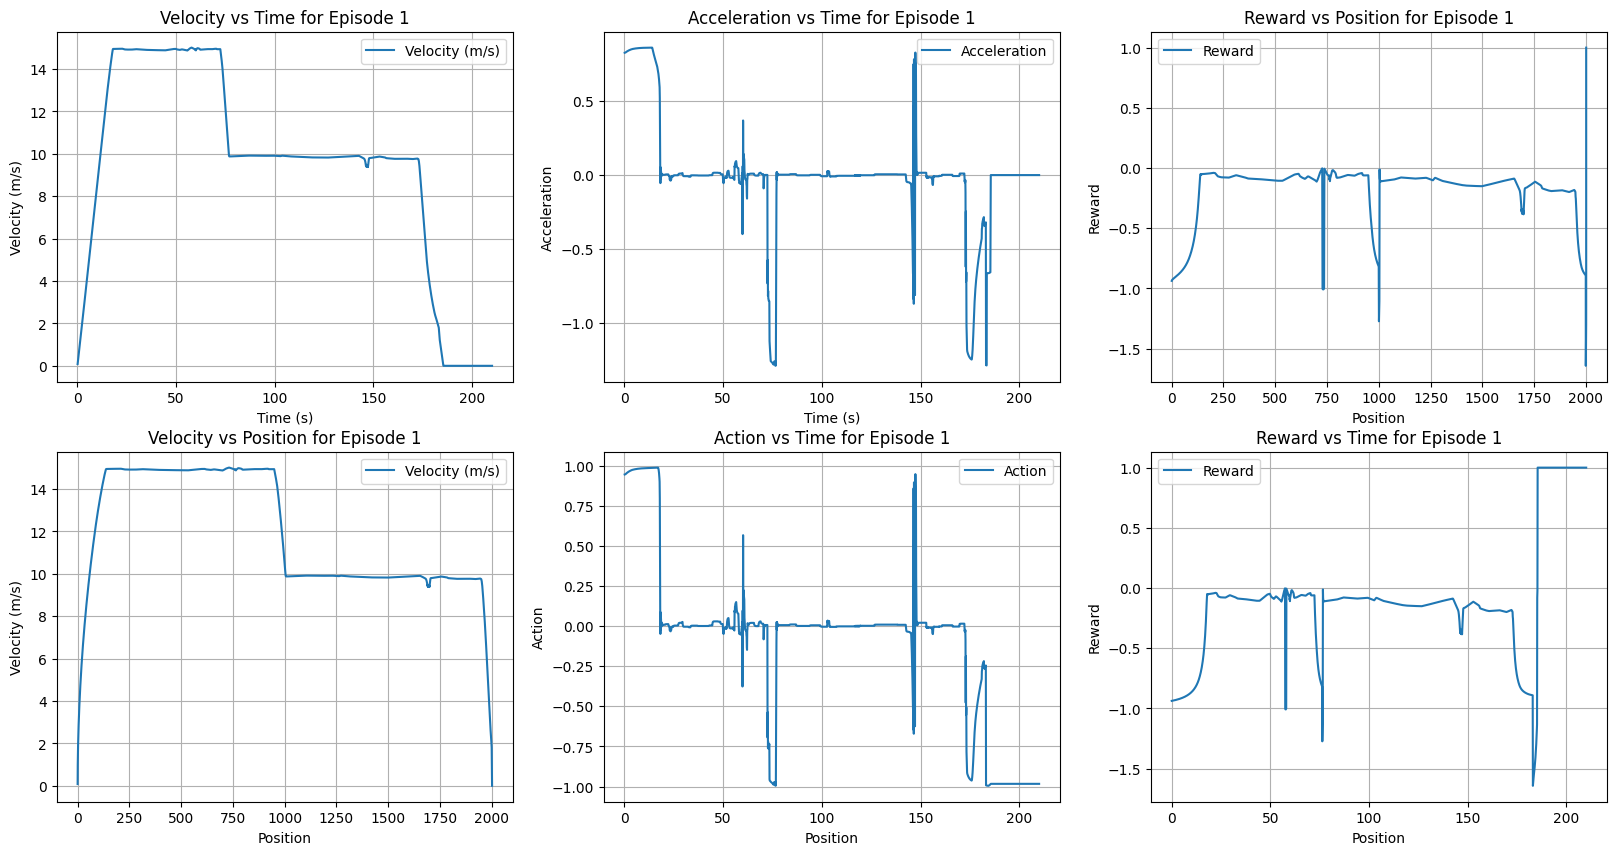

In [15]:
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 3, 1)
    plt.plot(time_data, velocity_data, label='Velocity (m/s)')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.title('Velocity vs Time for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 3, 2)
    plt.plot(time_data, acceleration_data, label='Acceleration')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration')
    plt.title('Acceleration vs Time for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 3, 3)
    plt.plot(position_data, reward_data, label='Reward')
    plt.xlabel('Position')
    plt.ylabel('Reward')
    plt.title('Reward vs Position for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 3, 4)
    plt.plot(position_data, velocity_data, label='Velocity (m/s)')
    plt.xlabel('Position')
    plt.ylabel('Velocity (m/s)')
    plt.title('Velocity vs Position for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 3, 5)
    plt.plot(time_data, action_data, label='Action')
    plt.xlabel('Position')
    plt.ylabel('Action')
    plt.title('Action vs Time for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 3, 6)
    plt.plot(time_data, reward_data, label='Reward')
    plt.xlabel('Position')
    plt.ylabel('Reward')
    plt.title('Reward vs Time for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)

    plt.show()

# Test of functions

<ipython-input-18-d50841e13e48>:23: RuntimeWarning: divide by zero encountered in scalar divide
  if f_t > (263.9 * 43 * 50 / (speed_km_h ** 2)):


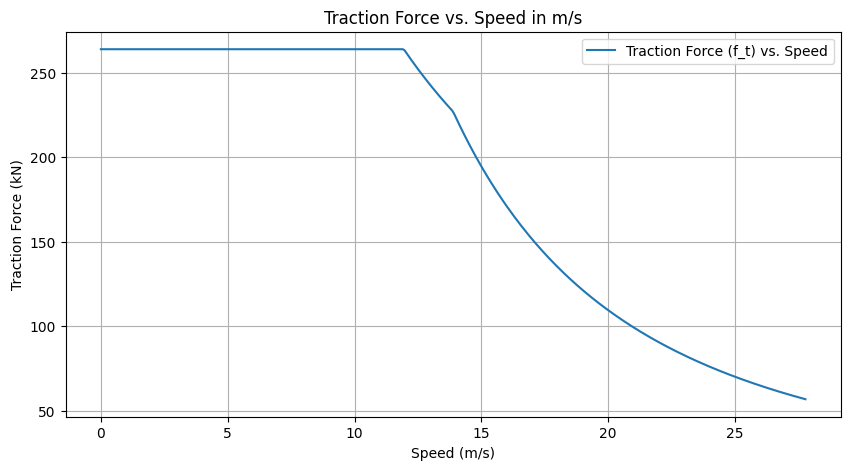

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def Calc_Max_traction_F(speed):
        """
        Calculate the traction force based on the speed in m/s.

        Parameters:
        - speed_m_s (float): Speed in m/s

        Returns:
        - float: Traction force in kN
        """
        speed_km_h = speed * 3.6  # Convert speed from m/s to km/h
        f_t = 263.9  # Initial traction force value in kN (acceleration phase)
        p_max = f_t * 43 / 3.6  # Maximum power during acceleration in kW

        # If power exceeds the maximum power limit, then limit the traction force
        if (f_t * speed_km_h / 3.6) > p_max:
            f_t = p_max / (speed_km_h / 3.6)

        # Additional condition to limit the traction force
        if f_t > (263.9 * 43 * 50 / (speed_km_h ** 2)):
            f_t = 263.9 * 43 * 50 / (speed_km_h ** 2)

        return f_t

# Generating data for the plot
speeds_m_s = np.linspace(0, 100 / 3.6, 400)  # Speeds from 0 to ~27.78 m/s (equivalent to 100 km/h)
traction_forces = [Calc_Max_traction_F(speed) for speed in speeds_m_s]

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(speeds_m_s, traction_forces, label='Traction Force (f_t) vs. Speed')
plt.title('Traction Force vs. Speed in m/s')
plt.xlabel('Speed (m/s)')
plt.ylabel('Traction Force (kN)')
plt.grid(True)
plt.legend()
plt.show()



In [ ]:
def Calc_Max_traction_F(speed):
        """
        Calculate the traction force based on the speed in m/s.

        Parameters:
        - speed_m_s (float): Speed in m/s

        Returns:
        - float: Traction force in kN
        """
        speed_km_h = speed * 3.6  # Convert speed from m/s to km/h
        f_t = 263.9  # Initial traction force value in kN (acceleration phase)
        p_max = f_t * 43 / 3.6  # Maximum power during acceleration in kW

        # If power exceeds the maximum power limit, then limit the traction force
        if speed_km_h > 0:
          if (f_t * speed_km_h / 3.6) > p_max:
              f_t = p_max / (speed_km_h / 3.6)

          # Additional condition to limit the traction force
          if f_t > (263.9 * 43 * 50 / (speed_km_h ** 2)):
              f_t = 263.9 * 43 * 50 / (speed_km_h ** 2)
        elif speed_km_h < 0:
            f_t = 263.9  # Set traction force to initial value if speed is 0
        return f_t
f = Calc_Max_traction_F(10)
print(f)

263.9


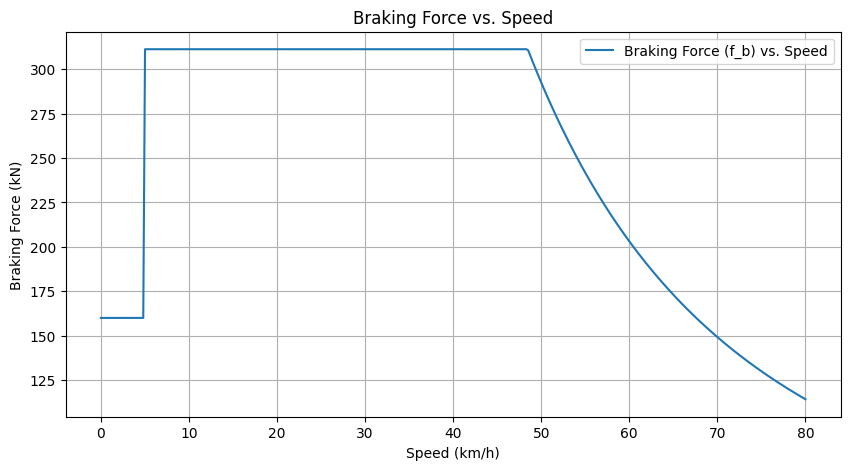

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def cal_braking(speed):
    """
    Calculate the braking force based on the speed.

    Parameters:
    - speed (float): Speed in km/h

    Returns:
    - float: Braking force in kN
    """
    if speed == 0:
        f_b = 200
    else:
        if speed >= 0 and speed <= 5:
            f_b = 200
        elif speed > 5 and speed <= 48.5:
            f_b = 389
        elif speed > 48.5 and speed <= 80:
            f_b = 913962.5 / (speed ** 2)
        else:
            f_b = 0  # Assumes no braking force calculation outside specified range

    # Apply a final modification factor to the braking force
    f_b = 0.8 * f_b

    return f_b

# Generating data for the plot
speeds = np.linspace(0, 80, 400)  # Speeds from 0 to 80 km/h
braking_forces = [cal_braking(speed) for speed in speeds]

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(speeds, braking_forces, label='Braking Force (f_b) vs. Speed')
plt.title('Braking Force vs. Speed')
plt.xlabel('Speed (km/h)')
plt.ylabel('Braking Force (kN)')
plt.grid(True)
plt.legend()
plt.show()


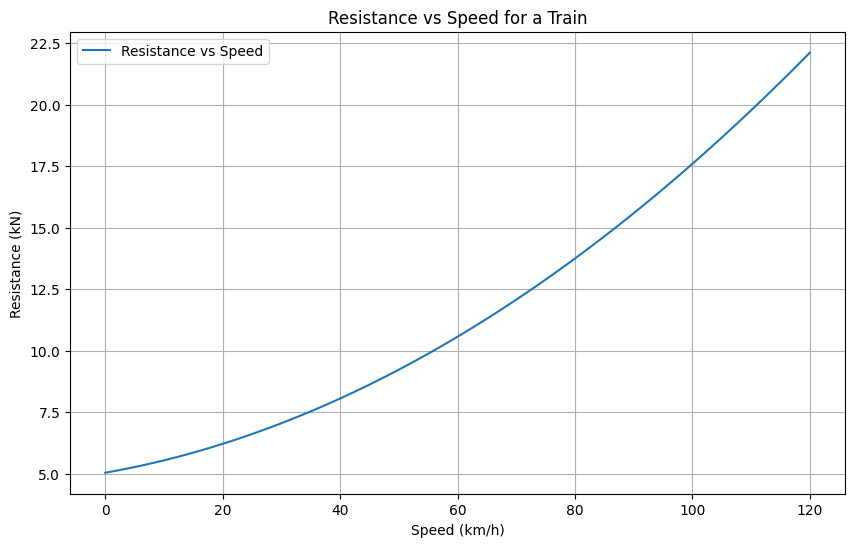

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Global variables
train_mass = 300  # Example mass of the train in Ton
n = 24  # Number of axles
N = 6  # Number of cars
A = 10.64  # Cross-sectional area of the train in m^2

def cal_resistance(speed):
    """
    Calculate the basic resistance of a train running at a given speed.

    :param speed: Speed of the train in km/h
    :return: Basic resistance in kN
    """
    f_r = (6.4 * train_mass + 130 * n + 0.14 * train_mass * speed +
           (0.046 + 0.0065 * (N - 1)) * A * speed**2) / 1000
    return f_r

# Speed range from 0 to 120 km/h
speeds = np.linspace(0, 120, 121)
resistances = [cal_resistance(speed) for speed in speeds]

# Plotting the resistance vs speed
plt.figure(figsize=(10, 6))
plt.plot(speeds, resistances, label='Resistance vs Speed')
plt.xlabel('Speed (km/h)')
plt.ylabel('Resistance (kN)')
plt.title('Resistance vs Speed for a Train')
plt.grid(True)
plt.legend()
plt.show()